<a href="https://colab.research.google.com/github/jrmelog/ML-models-tracking/blob/main/Neptune_Mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Model Tracking** - Fashion Mnist

Padrão para o log de modelos utilizando as ferramentas Neptune e DvC.

[Repositório Github](https://github.com/jrmelog/ML-models-tracking)

## Install


In [ ]:
! pip install neptune-client

In [ ]:
! pip install scikit-plot==0.3.7 tensorflow==2.4.1

## Imports

In [20]:
import neptune.new as neptune
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay, confusion_matrix
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Execution

###Neptune Config

É necessário informar os parâmetros da execução que serão acompanhados pelo Neptune. 

In [ ]:
#Parâmetros que serão utilizados.
EPOCH_NR = 5
BATCH_SIZE = 32
learning_rate = 0.001
optimizer = "SGD"
dataset = "Dataset50%"

# Inicialização do Neptune
run = neptune.init(project="jrmelog/mnist", api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJlMmNkYjZjZS0yMjBmLTQxZjktOGM4Yi03MmE4YzBjNjFjNzgifQ==")

# Informando quais parâmetros serão acompanhados. 
run['parameters/learning_rate'] = learning_rate
run["parameters/epoch_nr"] = EPOCH_NR
run["parameters/batch_size"] = BATCH_SIZE
run["parameters/optimizer"] = optimizer

run["sys/name"] = "mnist"
run["sys/tags"].add(dataset)

In [143]:
from tensorflow.keras.callbacks import Callback


class NeptuneLogger(Callback):
    def on_batch_end(self, batch, logs={}):
        for log_name, log_value in logs.items():
            run["batch/{}".format(log_name)].log(log_value)

    def on_epoch_end(self, epoch, logs={}):
        for log_name, log_value in logs.items():
            run["epoch/{}".format(log_name)].log(log_value)

##Load Data

In [144]:
# Carrregando os dados iniciais 

x_train = pd.read_pickle("/content/drive/MyDrive/IARIS/Workflow/data/x_train_half.pkl")
y_train = pd.read_pickle("/content/drive/MyDrive/IARIS/Workflow/data/y_train_half.pkl")

x_test = pd.read_pickle("/content/drive/MyDrive/IARIS/Workflow/data/x_test_half.pkl")
y_test = pd.read_pickle("/content/drive/MyDrive/IARIS/Workflow/data/y_test_half.pkl")

###Creating Model

In [148]:
SGD = tf.keras.optimizers.SGD(
    learning_rate, momentum=0.0, nesterov=False, name="SGD")

Adam = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [149]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(512, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(10, activation="softmax"),
    ]
)

model.compile(
    optimizer=SGD, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

###Run

In [150]:
history = model.fit(
    x=x_train,
    y=y_train,
    epochs=EPOCH_NR,
    batch_size=BATCH_SIZE,
    validation_data=(x_test, y_test),
    callbacks=[NeptuneLogger()],
)

Epoch 1/5
938/938 [==============================] - 8s 8ms/step - loss: 1.8837 - accuracy: 0.3757 - val_loss: 1.2008 - val_accuracy: 0.6546
Epoch 2/5
938/938 [==============================] - 7s 7ms/step - loss: 1.1361 - accuracy: 0.6638 - val_loss: 0.9608 - val_accuracy: 0.6894
Epoch 3/5
938/938 [==============================] - 5s 6ms/step - loss: 0.9382 - accuracy: 0.7101 - val_loss: 0.8533 - val_accuracy: 0.7194
Epoch 4/5
938/938 [==============================] - 5s 5ms/step - loss: 0.8386 - accuracy: 0.7338 - val_loss: 0.7925 - val_accuracy: 0.7386
Epoch 5/5
938/938 [==============================] - 5s 5ms/step - loss: 0.7836 - accuracy: 0.7483 - val_loss: 0.7495 - val_accuracy: 0.7492


### Results

In [151]:
import numpy as np

y_test_pred = np.asarray(model.predict(x_test))
y_test_pred_class = np.argmax(y_test_pred, axis=1)

In [152]:
from sklearn.metrics import f1_score

run["test/f1"] = f1_score(y_test, y_test_pred_class, average="micro")

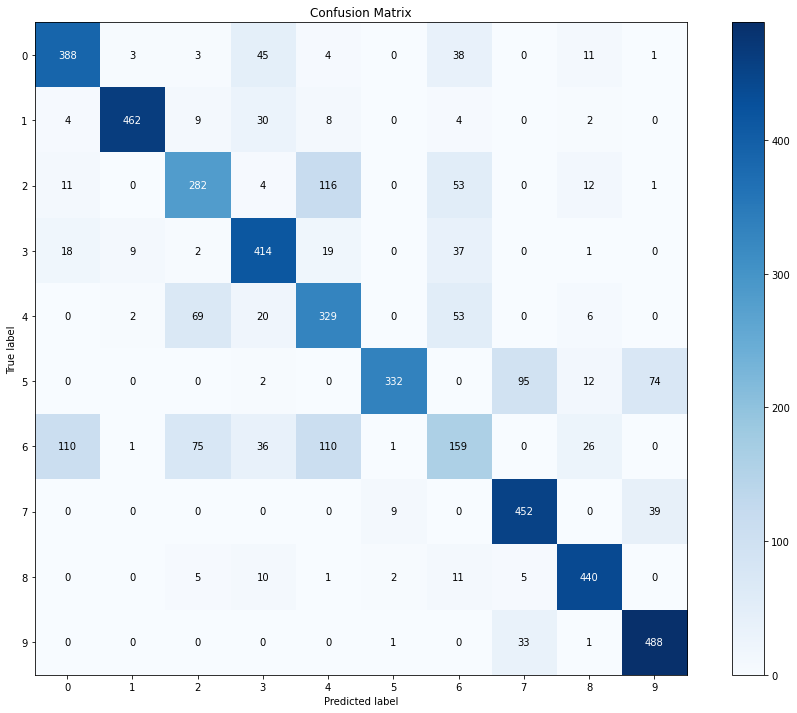

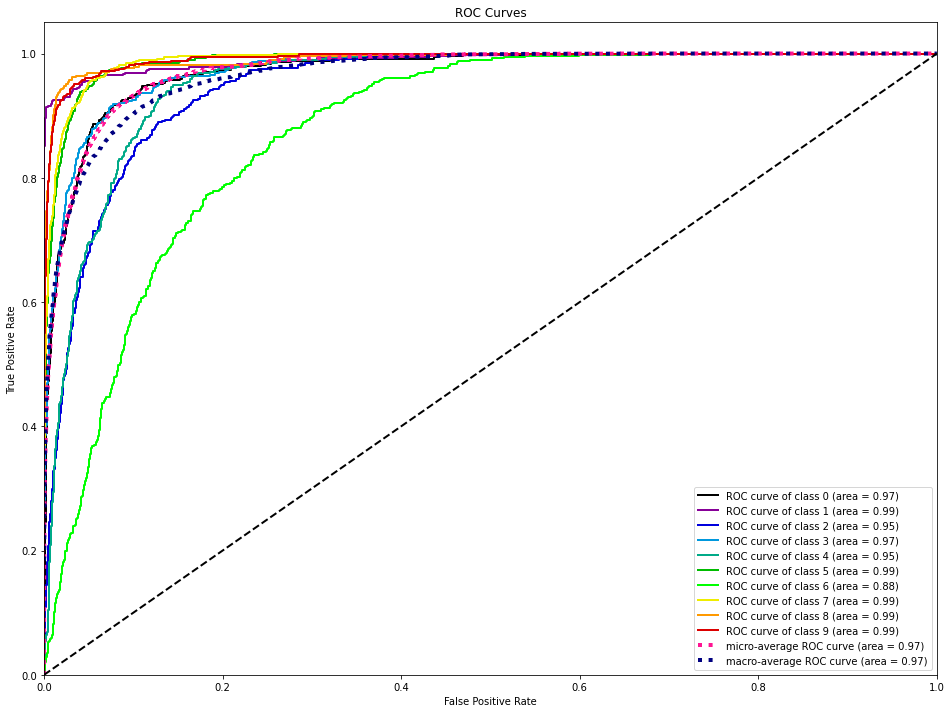

In [153]:
import matplotlib.pyplot as plt
from scikitplot.metrics import plot_confusion_matrix, plot_roc

fig, ax = plt.subplots(figsize=(16, 12))
plot_confusion_matrix(y_test, y_test_pred_class, ax=ax)
run["diagnostic_charts"].log(neptune.types.File.as_image(fig))

fig, ax = plt.subplots(figsize=(16, 12))
plot_roc(y_test, y_test_pred, ax=ax)
run["diagnostic_charts"].log(neptune.types.File.as_image(fig))

### Save Model

In [154]:
model.save("my_model.h5")
run["model"].upload("my_model.h5")

[Referência HDF5](https://stackoverflow.com/questions/42763094/how-to-save-final-model-using-keras/42763323#42763323)

In [155]:
model.save(f'/content/drive/MyDrive/IARIS/Workflow/models/{dataset}model{optimizer}{str(learning_rate)}.hdf5')

###Stop logging

<font color=red>**Warning:**</font><br>

É necessário finalizar a execução do Neptune.

In [ ]:
run.stop()